# Exposure Time Predictor
Use observing conditions (sampled at earliest a few min ago, and many older points) to predict exposure time for next exposure at a new position, airmass, etc

### Features vs. Answers
 * Features: obsdb statistics since that's what see when observing
 * Answers: expfactor using depth in CP images as that's what actually wan to achieve, which is NOT expfactor column in the obsdb db! 

### Prediction
expfactor (exptime divided by a given band's nominal)

### Features

### Notes
 * supervised
 * online or batch?
 * regression classifier, model based
 * performance: RMSE
 * scaling of features: expfactor 
 * cleaning
  - transp > 0.9 for 50 consecutive exposures

# Starting where "addylabel_and_splittraintest" left off

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_context("notebook")

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

REPO_DIR= os.path.join(os.environ['HOME'],
                       'PhdStudent/Research/desi/ml_data/')
DB_DIR= os.path.join(REPO_DIR,'obsbot/obsdb')

In [2]:
from exptime_predictor.data import GetData,Clean,AddYlabel,Split_TrainTest
d= GetData(REPO_DIR)
d.fetch()
df = d.load()

df= Clean().keep_science_exposures(df)
df= Clean().add_night_obs(df)
df= Clean().order_by_mjd(df)
df= Clean().add_hr_obs(df)

#df= Clean().drop_bad_transp(df, thresh=0.9)
df= Clean().drop_nights_wfew_exposures(df, nexp=20)

df= AddYlabel().add_tneed(df)
df= AddYlabel().constrain_tneed(df)

df_train,df_test= Split_TrainTest().random_sampling(df)
# Prevent accidental ref to full data set
del df

UNIX cmd: git pull origin master
UNIX cmd: git checkout 84d63bb9aa33b
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd
isGRZ 24116/28833
isObject 21758/28833
isScience 20991/28833
longExp 21750/28833
allCuts 20955/28833
Cutting to < 20 exposures: 20617/20955
Cutting to 19286/20617


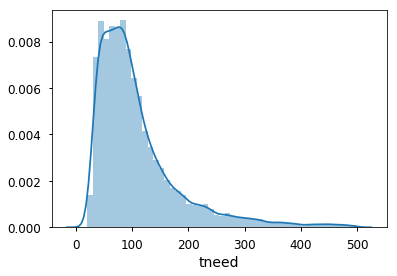

In [3]:
sns.distplot(df_train['tneed'])

In [4]:
corr_matrix = df_train.corr()
corr_matrix["tneed"].sort_values(ascending=False)

tneed           1.000000
expfactor       0.904561
exptime         0.613254
seeing          0.570651
passnumber      0.375741
airmass         0.358016
tileid          0.338832
deccenter       0.195621
decbore         0.195618
ebv             0.178871
tileebv         0.169003
id              0.097754
affine_dyx      0.078933
affine_dxx      0.051025
affine_dyy      0.050933
affine_y0       0.050858
affine_x0       0.050858
nmatched        0.040187
mjd_obs         0.039485
expnum          0.033359
night_obs      -0.005901
affine_dx      -0.009988
dx             -0.037988
hr_obs         -0.045297
affine_dxy     -0.047865
dy             -0.052839
affine_dy      -0.081208
racenter       -0.081681
rabore         -0.081991
sky            -0.102856
transparency   -0.344165
zeropoint      -0.536643
bad_pixcnt           NaN
readtime             NaN
Name: tneed, dtype: float64

# Inspect nights with 50-200 exposures

In [5]:
a=df_train['night_obs'].value_counts().rename("cnt").to_frame()
nights= a.index[ (a['cnt'] > 50) & (a['cnt'] < 200)]
nights= nights.values
np.sort(nights)

array([20141229, 20141230, 20151027, 20160107, 20160226, 20160410,
       20160606, 20160810, 20161114, 20161220, 20170110, 20170405,
       20170418, 20170503, 20170731])

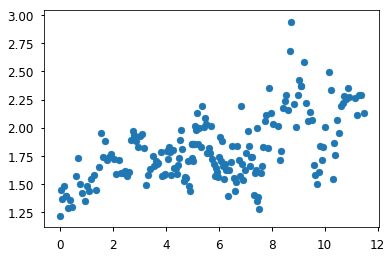

In [6]:
isNight= df_train['night_obs'] == nights[0]
plt.scatter(df_train.loc[isNight,'hr_obs'],
            df_train.loc[isNight,'seeing'])

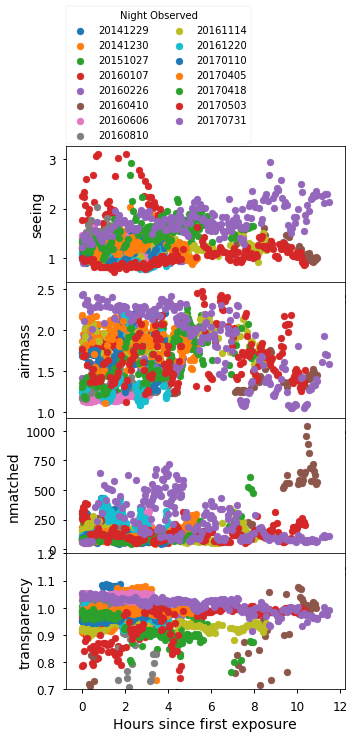

In [9]:
stats= ['seeing','airmass','nmatched','transparency']
lims= dict(seeing= None,
           transparency=[0.7,1.2],
           airmass=None,
           nmatched=None)

fig,ax= plt.subplots(len(stats),1,figsize=(5,10))
plt.subplots_adjust(hspace=0)

for night in np.sort(nights):
    #if '2014' in str(night):
    isNight= df_train['night_obs'] == night
    for iax,stat in enumerate(stats):
        ax[iax].scatter(df_train.loc[isNight,'hr_obs'],
                        df_train.loc[isNight,stat],
                        label= night)
    leg= ax[0].legend(loc=(0,1.01),ncol=2,title='Night Observed')
    xlab= ax[-1].set_xlabel('Hours since first exposure')
    for iax,stat in enumerate(stats):
        ylab= ax[iax].set_ylabel(stat)
        if lims[stat]:
            ax[iax].set_ylim(lims[stat])

# Repackage for ML

In [10]:
df_train['obstype'].value_counts()

object    10265
Name: obstype, dtype: int64

In [11]:
df_train['object'].value_counts().head(20)

DECaLS_44956_z    5
DECaLS_17034_r    4
DECaLS_36588_z    4
DECaLS_41491_z    3
DECaLS_23567_z    3
DECaLS_38471_z    3
DECaLS_36587_z    3
DECaLS_36589_z    3
DECaLS_8494_z     2
DECaLS_10851_g    2
DECaLS_11697_g    2
DECaLS_38424_z    2
DECaLS_6392_g     2
DECaLS_20386_g    2
DECaLS_39636_z    2
DECaLS_11775_r    2
DECaLS_18757_r    2
DECaLS_36553_z    2
DECaLS_5060_g     2
DECaLS_11776_g    2
Name: object, dtype: int64

In [12]:
df_train[df_train['object'].str.lower().str.contains('decals') == False]['exptime'].value_counts()

Series([], Name: exptime, dtype: int64)

In [13]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(df_train['band'])
print(encoder.classes_)
housing_cat_1hot

['g' 'r' 'z']


array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ..., 
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from exptime_predictor.ml import df2array,df2binary,MyPipelines

categ_cols = ['band','passnumber']
not_num_cols= ['bad_pixcnt','readtime','expnum',
               'id','tileid','expfactor',
               'object','obstype','extension',
               'filename','camera','md5sum','tneed'] + categ_cols

num_cols = list(df_train.columns)
for col in not_num_cols:
    num_cols.remove(col)
print('numerical cols= ',num_cols)
print('categorical cols= ',categ_cols)

num_pipeline = MyPipelines().num(num_cols) 
cat_pipeline = MyPipelines().cat(categ_cols) 

# fit_transform() takes DataFrame and
# applies all cleaning needed for ML
pipe = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

numerical cols=  ['exptime', 'mjd_obs', 'airmass', 'racenter', 'deccenter', 'rabore', 'decbore', 'ebv', 'zeropoint', 'transparency', 'seeing', 'sky', 'dx', 'dy', 'nmatched', 'tileebv', 'affine_dx', 'affine_dxx', 'affine_dxy', 'affine_dy', 'affine_dyx', 'affine_dyy', 'affine_x0', 'affine_y0', 'night_obs', 'hr_obs']
categorical cols=  ['band', 'passnumber']
(10265, 33) (10265,)


In [19]:
# ready some Batch data for ML
x_batch= pipe.fit_transform(df_train)
y_batch= df_train['tneed'].copy().values
print(x_batch.shape,y_batch.shape)

(10265, 33) (10265,)


# Select and train a model 

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_batch, y_batch)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
# MSE
mse= np.average(np.power(y_batch - lin_reg.predict(x_batch),2))
rmse= np.sqrt(mse)
print(rmse,mse)

25.6781508366 659.367430386


In [22]:
for ans,pred in zip(y_batch[:10],lin_reg.predict(x_batch)[:10]):
    print(ans,pred)

80.1095440448 96.8467300267
67.2457169555 66.1190517735
66.4430609872 68.3699251469
63.2717156722 58.6701625016
68.4487442655 66.4129618757
75.3074656415 79.7297080529
78.4270230509 81.9585579299
76.0744410282 80.1328466805
70.0221625202 68.2371478249
62.4212647704 55.0809151576


In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=7)
tree_reg.fit(x_batch, y_batch)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=7,
           splitter='best')

In [26]:
# MSE
mse= np.average(np.power(y_batch - tree_reg.predict(x_batch),2))
rmse= np.sqrt(mse)
print(rmse,mse)

5.22409313621e-06 2.72911490957e-11


# Tune

In [123]:
cross_val_score?

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, x_batch, y_batch,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
pd.Series(tree_rmse_scores).describe()

count    10.000000
mean     40.394076
std      12.591265
min      22.960739
25%      34.170933
50%      37.325259
75%      43.771103
max      69.499148
dtype: float64

In [33]:
lin_scores = cross_val_score(lin_reg, x_batch, y_batch,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
pd.Series(lin_rmse_scores).describe()

count    1.000000e+01
mean     3.214968e+07
std      1.016661e+08
min      2.121705e+01
25%      2.437553e+01
50%      2.630891e+01
75%      3.565486e+01
max      3.214965e+08
dtype: float64

In [30]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=7)
forest_reg.fit(x_batch, y_batch)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

In [31]:
mse= np.average(np.power(y_batch - forest_reg.predict(x_batch),2))
rmse= np.sqrt(mse)
print(rmse,mse)

8.31195902631 69.0886628551


In [35]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, x_batch,y_batch,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
pd.Series(forest_rmse_scores).describe()

count    10.000000
mean     27.505738
std       7.068849
min      14.933762
25%      23.196090
50%      27.808269
75%      31.054750
max      38.679920
dtype: float64

In [86]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [132]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [133]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [134]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [140]:
cvres.keys()

dict_keys(['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params'])

In [141]:
cvres = grid_search.cv_results_
for mean_score,std_score, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),np.sqrt(std_score), params)

63825.0479302 10773.5494371 {'max_features': 2, 'n_estimators': 3}
55643.8429091 11392.1873564 {'max_features': 2, 'n_estimators': 10}
53380.6566859 12623.9806065 {'max_features': 2, 'n_estimators': 30}
60959.1388585 13000.1105598 {'max_features': 4, 'n_estimators': 3}
52740.5841667 11307.0704473 {'max_features': 4, 'n_estimators': 10}
50374.1421461 10999.7030522 {'max_features': 4, 'n_estimators': 30}
58661.2866462 13726.7206754 {'max_features': 6, 'n_estimators': 3}
52009.9739798 12103.567305 {'max_features': 6, 'n_estimators': 10}
50154.1177737 11329.5185722 {'max_features': 6, 'n_estimators': 30}
57865.3616801 11075.5701016 {'max_features': 8, 'n_estimators': 3}
51730.0755087 11803.6128258 {'max_features': 8, 'n_estimators': 10}
49694.8514333 10437.4105116 {'max_features': 8, 'n_estimators': 30}
62874.4073931 13778.666248 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.9398157 12559.5161223 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59416.6463145 8

In [91]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.055782,0.003593,-4.073637e+09,-1.107354e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.963584e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.000631,0.000542,1.160694e+08,1.927217e+07
1,0.172177,0.008357,-3.096237e+09,-5.813707e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.070368e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.002452,0.000872,1.297819e+08,6.782553e+06
2,0.549370,0.024622,-2.849495e+09,-4.394633e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.697829e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.031675,0.001817,1.593649e+08,2.961109e+06
3,0.108659,0.003603,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.005413,0.000532,1.690029e+08,4.047487e+07
4,0.345844,0.010100,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.005767,0.001052,1.278498e+08,1.498960e+07
5,0.890049,0.025157,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.040411,0.001709,1.209935e+08,8.424973e+06
6,0.134878,0.003163,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.003447,0.000230,1.884229e+08,2.639683e+07
7,0.441237,0.009476,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.026262,0.001327,1.464963e+08,3.357661e+06
8,1.293729,0.025095,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.043359,0.000991,1.283580e+08,3.796810e+06
9,0.154177,0.003283,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.002721,0.000364,1.226683e+08,2.730057e+07


In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb978>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff6886eb630>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [93]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50798.3025423 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50776.7360494 {'max_features': 3, 'n_estimators': 75}
50682.7075546 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50472.6107336 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


In [94]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [95]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813418, 'median_income'),
 (0.16478099356159051, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.073344235516012421, 'longitude'),
 (0.062909070482620302, 'latitude'),
 (0.056419179181954007, 'rooms_per_hhold'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.0019604155994780701, 'NEAR BAY'),
 (6.0280386727365991e-05, 'ISLAND')]

In [96]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [97]:
final_rmse

47766.003966433083

## Model persistence using joblib

In [99]:
my_model = full_pipeline_with_predictor

In [100]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF